In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from analyze import *

Found 15 experiment in series 4dosa
perf vs cpu data/4dosa
Getting perf data
Aggregating perf data
340redis_ycsb
561redis_ycsb_wrk
502redis_ycsb_hadoop
343redis_ycsb_linpack
584wrk_redis_ycsb
567wrk_linpack
348hadoop_redis_ycsb
349hadoop_wrk
351hadoop_linpack
352linpack_redis_ycsb
353linpack_wrk
514linpack_hadoop
355linpack


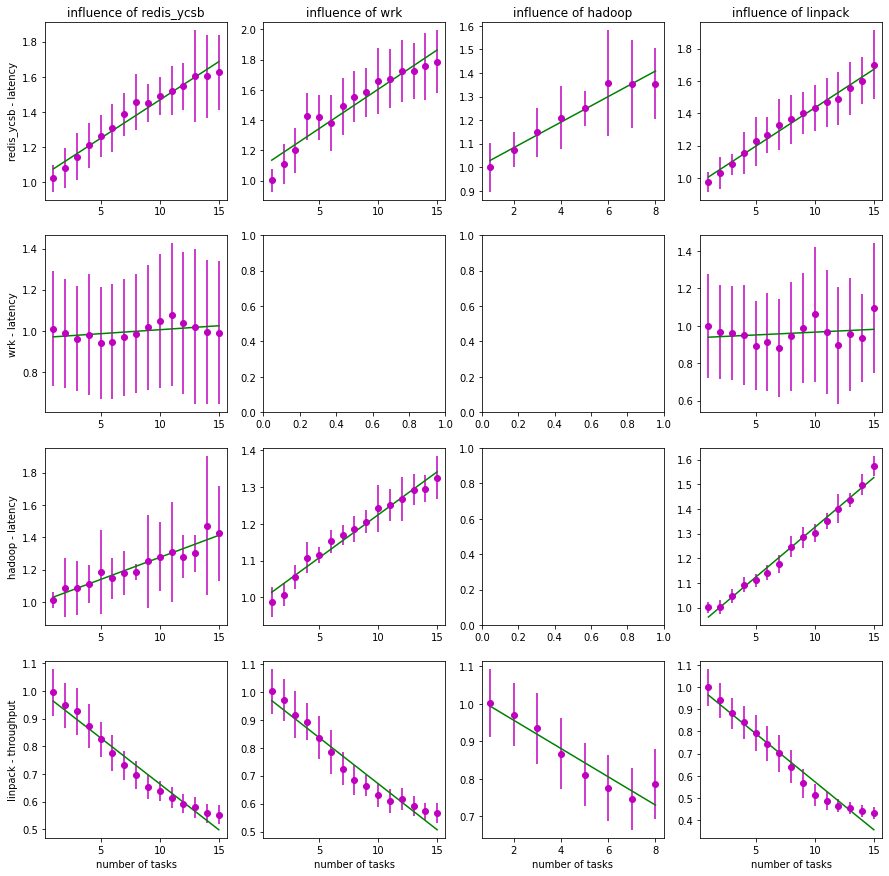

array([[[0.04354289, 0.05203064, 0.05422121, 0.04760939],
        [0.00386077, 0.        , 0.        , 0.00300572],
        [0.02727722, 0.02337016, 0.        , 0.040372  ],
        [0.03317586, 0.03303273, 0.03770084, 0.04336191]]])

In [4]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/4dosa" 
s4 = ExperimentSeries(path, tasks, {"hadoopslave": 2})
readPerfVsCpu(s4, skip_cpu=True)

# df.loc[(df["t1"] == "linpack") & (df["t2"] == "redis_ycsb"), :]
df = s4.df
#df.loc[(df["t1"] == "wrk") & (df["t2"] == "redis_yscb")]
#("redis_ycsb", "wrk"), ("wrk", "redis_ycsb"), 
analyzeInterferenceGrid([s4], [s4.df], skip_tasks=[("wrk", "wrk"), \
                ("wrk", "hadoop")])
#, ("wrk", "linpack")

320redis_ycsb
361redis_ycsb_wrk
202redis_ycsb_hadoop
323redis_ycsb_linpack
304wrk_redis_ycsb
306wrk_hadoop
307wrk_linpack
230hadoop
271hadoop_linpack
332linpack_redis_ycsb
214linpack_hadoop
335linpack


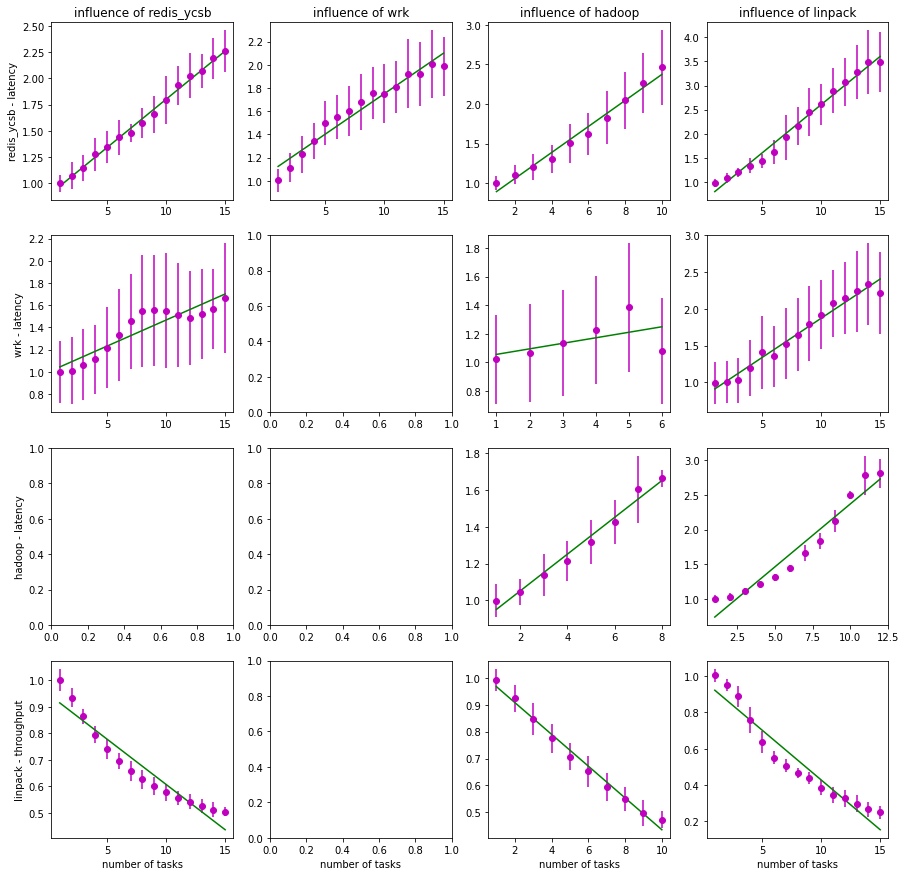

array([[[0.0921132 , 0.06967669, 0.16412314, 0.19980557],
        [0.04699303, 0.        , 0.03872966, 0.10687533],
        [0.        , 0.        , 0.10007268, 0.18088171],
        [0.03420696, 0.        , 0.05908368, 0.05479816]]])

In [6]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/3more_tasks_hadoop" 
#s3 = ExperimentSeries(path, tasks, {"hadoopslave": 2})
#readPerfVsCpu(s3, skip_cpu=True)

# df.loc[(df["t1"] == "linpack") & (df["t2"] == "redis_ycsb"), :]
df = s3.df
#df.loc[(df["t1"] == "wrk") & (df["t2"] == "redis_yscb")]
#("redis_ycsb", "wrk"), ("wrk", "redis_ycsb"), 
analyzeInterferenceGrid([s3], [s3.df], skip_tasks=[])

In [4]:
def readExpSeries(options):
    tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
    synthetic_tasks = ["filebench", "netperf", "unixbench"]
    tasks_list = [tasks, tasks, synthetic_tasks, tasks]
    paths = ["2more_tasks", "3more_tasks_hadoop", "5synthetic", "6cpu_diff"]
    hadoop2 = {"hadoopslave": 2}
    task_counts = [{}, hadoop2, hadoop2, hadoop2]
    exp_series_list = []
    for ts, path, task_count in zip(tasks_list, paths, task_counts):
        exp_series_list.append(ExperimentSeries(os.path.join("data", path), ts, task_count, options))
    for exp_series in exp_series_list:
        readPerfVsCpu(exp_series)
    return exp_series_list
    
exp_series_list = readExpSeries({})
s2, s3, s5, s6 = exp_series_list
#exp_series = readExpSeries({"interval_boundaries": "first_plus_interval"})

Found 15 experiment in series 2more_tasks
Found 12 experiment in series 3more_tasks_hadoop
Found 8 experiment in series 5synthetic
Found 3 experiment in series 6cpu_diff
perf vs cpu data/2more_tasks
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data
perf vs cpu data/3more_tasks_hadoop
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data
perf vs cpu data/5synthetic
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data
perf vs cpu data/6cpu_diff
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data


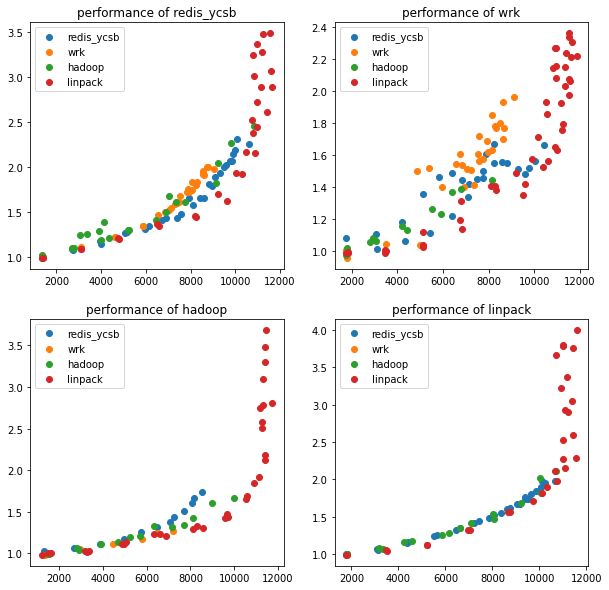

In [84]:
printPerfVsCpuMultipleSeries([s2, s3, s6])

[[0.01664118]
 [0.01033656]
 [0.00530761]]


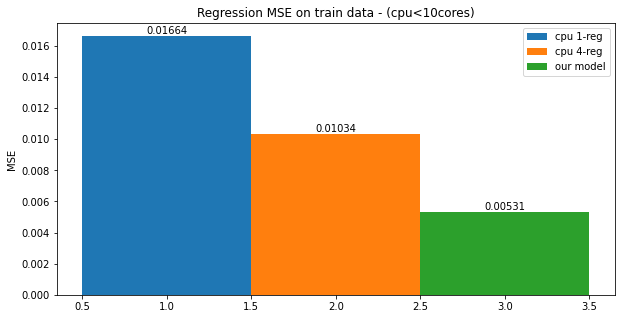

[[0.10855242]
 [0.08507608]
 [0.0068349 ]]


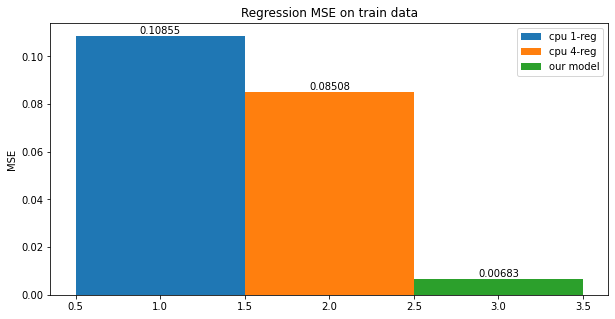

In [87]:
def getMSEForExperimentSeries(exp_series, limits):
    regression_levels = ["all", "t1", "t2"]
    x_labels = ["avg_cpu", "avg_cpu", "tasks"]
    results = np.zeros((len(limits), len(regression_levels)))
    for i, limit in enumerate(limits):
        for j, regression_level in enumerate(regression_levels):
            results[i, j] = computeMSE(exp_series, x_labels[j], regression_level, limit)
    return results

limits = [10000., 12000.]
s2_mse = getMSEForExperimentSeries(s2, limits)
s3_mse = getMSEForExperimentSeries(s3, limits)
def printMSEBarChart(data, title, precision=5):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    labels = ["cpu 1-reg", "cpu 4-reg", "our model"]
    rects = []
    for i, series_label in enumerate(zip(data, labels)):
        series, label = series_label
        series = [round(v, precision) for v in series]
        xs = [i + 1 + 4 * j for j in range(len(series))]
        rects.append(ax.bar(xs, series, 1., label=label))
    ax.set_title(title)
    ax.set_ylabel("MSE")
    for rects1 in rects:
        for rect in rects1:
            height = rect.get_height()
            ax.annotate(f"{height}", xy=(rect.get_x() + rect.get_width() / 2, height),
                ha='center', va='bottom')
    ax.legend()
    plt.show()
title = "Regression MSE on train data"
limit = s2_mse[0].reshape((-1, 1))
no_limit = s2_mse[1].reshape((-1, 1))
print(limit)
printMSEBarChart(limit, "Regression MSE on train data - (cpu<10cores)")
print(no_limit)
printMSEBarChart(no_limit, "Regression MSE on train data")

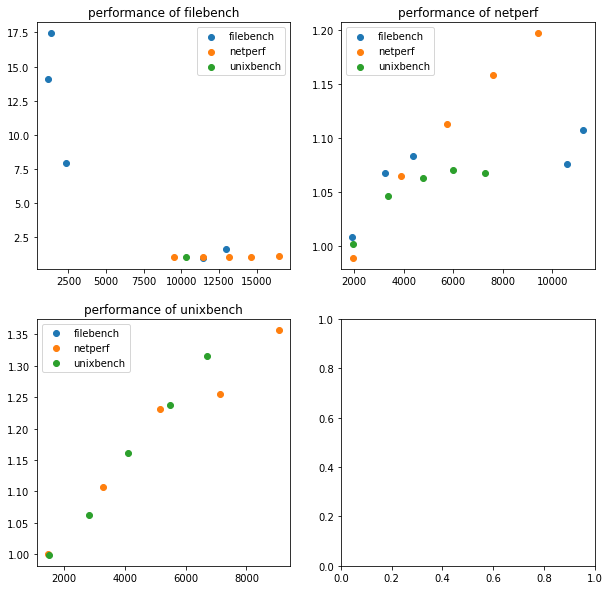

In [43]:
printPerfVsCpuMultipleSeries([s5])

Found 8 experiment in series 5synthetic
perf vs cpu data/5synthetic
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data


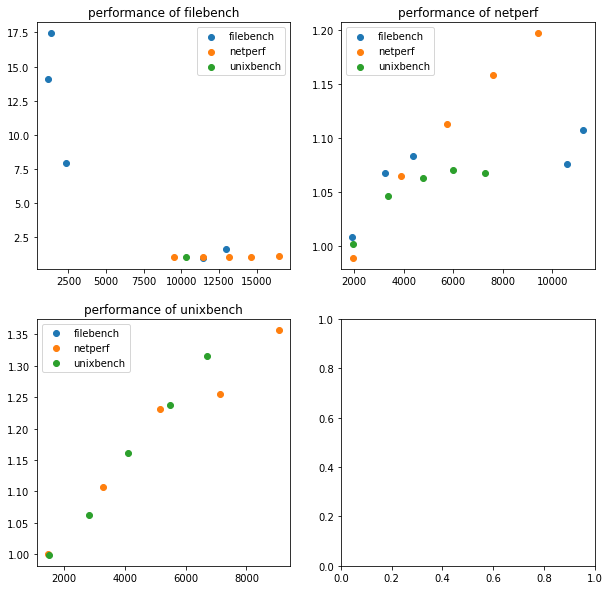

In [102]:
tasks = ["filebench", "netperf", "unixbench"]
path = "5synthetic"
s5 = ExperimentSeries(os.path.join("data", path), tasks, {}, {})
readPerfVsCpu(s5)
printPerfVsCpu(s5)

2more_tasks


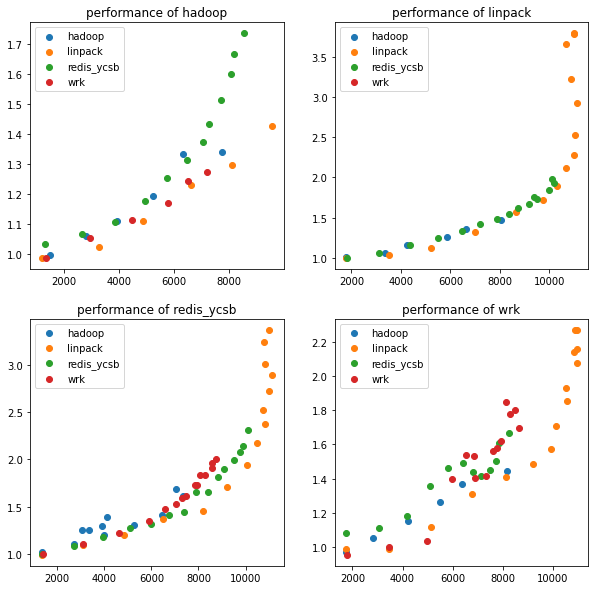

3more_tasks_hadoop


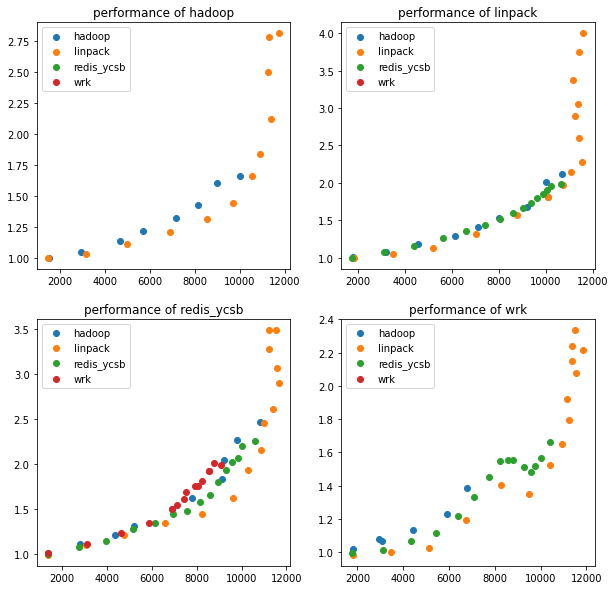

5synthetic


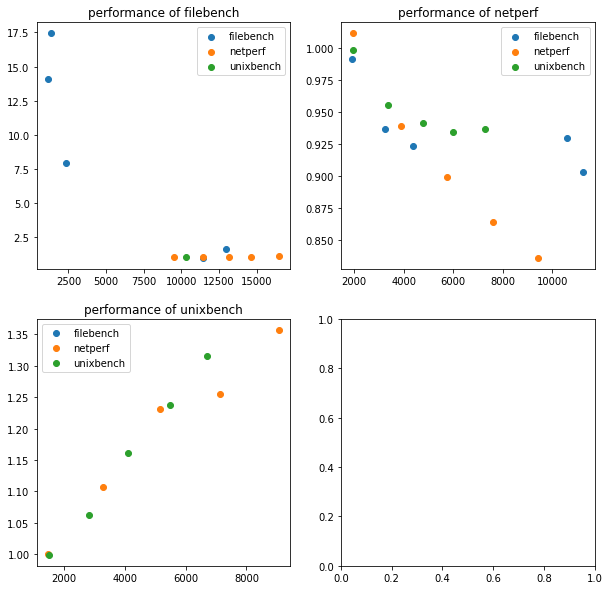

6cpu_diff


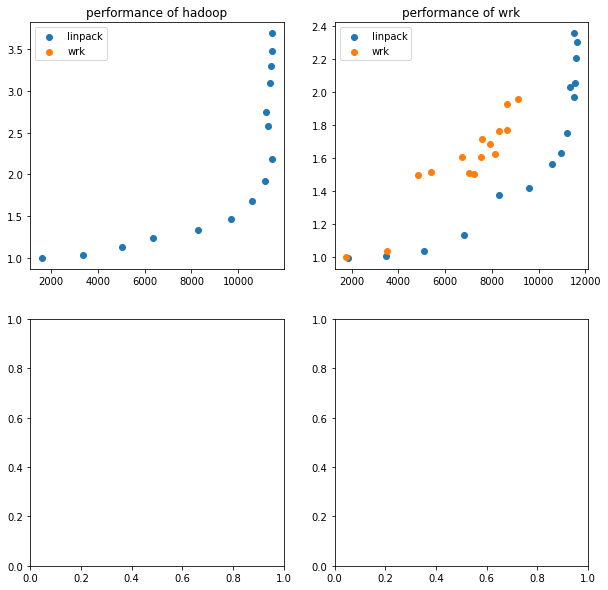

In [100]:
for exp_series1 in exp_series_list:
    print(f"{exp_series1.name}")
    printPerfVsCpu(exp_series1, exp_series1.df)

In [41]:
df = res_s5["perf_vs_cpu"]
pd.set_option("display.max_columns", 30)
#cols = ["t1", "t2", "tasks"]
#cols += [c for c in df.columns if ("throughput" in c) or ("cpu" in c)]
df.loc[(df["t1"] == "filebench") & (df["ai_no"] == 1), :]

,expid,t1,t2,tasks,avg_cpu,std_cpu,cpu_samples_count,ai_no,avg_throughput,std_throughput,throughput_samples_count,throughput_quantile25,throughput_quantile50,throughput_quantile75,avg_bandwidth,std_bandwidth,bandwidth_samples_count,bandwidth_quantile25,bandwidth_quantile50,bandwidth_quantile75,avg_throughput_rescaled,std_throughput_rescaled,avg_bandwidth_rescaled,std_bandwidth_rescaled
0,500filebench,filebench,filebench,1,11470.727273,1970.872352,22,1,201693.665625,8682.401058,16.0,196578.22575,199446.5685,203334.61500,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.043047,NaN,NaN
1,500filebench,filebench,filebench,2,12964.461538,6273.781474,52,1,118669.111368,35065.386996,19.0,120204.80400,126320.1450,138698.93350,NaN,NaN,NaN,NaN,NaN,NaN,0.588363,0.173855,NaN,NaN
3,500filebench,filebench,filebench,3,2362.242063,2588.759453,83,1,24202.418917,5783.831098,12.0,20055.09900,21101.9580,27373.48600,NaN,NaN,NaN,NaN,NaN,NaN,0.119996,0.028676,NaN,NaN
6,500filebench,filebench,filebench,4,1151.310084,1620.884544,137,1,13607.200273,7112.411229,11.0,11448.46800,12365.8710,15041.28900,NaN,NaN,NaN,NaN,NaN,NaN,0.067465,0.035263,NaN,NaN
10,500filebench,filebench,filebench,5,1336.287500,2348.810708,76,1,10984.617500,8659.191739,4.0,5630.11675,8325.0910,13679.59175,NaN,NaN,NaN,NaN,NaN,NaN,0.054462,0.042932,NaN,NaN
15,501filebench_netperf,filebench,netperf,1,9492.478261,2299.516033,23,1,192326.479824,9504.110579,17.0,194578.35700,195663.3370,196271.01800,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.049417,NaN,NaN
16,501filebench_netperf,filebench,netperf,2,11448.887352,1801.493072,68,1,189939.441875,7417.699177,16.0,190304.29450,192630.9935,193103.68875,NaN,NaN,NaN,NaN,NaN,NaN,0.987589,0.038568,NaN,NaN
18,501filebench_netperf,filebench,netperf,3,13156.130435,1519.268635,116,1,189470.608412,5802.787007,17.0,189229.05700,192487.0310,193187.54400,NaN,NaN,NaN,NaN,NaN,NaN,0.985151,0.030172,NaN,NaN
21,501filebench_netperf,filebench,netperf,4,14646.506258,1940.796685,160,1,185278.031111,9789.710885,18.0,179854.51425,189971.4600,192063.34800,NaN,NaN,NaN,NaN,NaN,NaN,0.963352,0.050902,NaN,NaN
25,501filebench_netperf,filebench,netperf,5,16470.964912,2223.041009,165,1,178678.375077,11868.604443,13.0,168647.16100,176326.7280,192136.82900,NaN,NaN,NaN,NaN,NaN,NaN,0.929037,0.061711,NaN,NaN


In [1]:
data = res_s5["perf_vs_cpu"]
#printPerfVsCpu(res_s5["perf_vs_cpu"])
analyzeInterferenceGrid([s5], [res_s5["perf_vs_cpu"]])
#rescalePerfVsCpu(s5, data)
data.loc[(data["t1"] == "netperf") & (data["ai_no"] == 1), :]

NameError: name 'res_s5' is not defined

# Performance vs cpu

101redis_ycsb
320redis_ycsb
102redis_ycsb_wrk
172redis_ycsb_hadoop
202redis_ycsb_hadoop
103redis_ycsb_linpack
323redis_ycsb_linpack
174wrk_redis_ycsb
304wrk_redis_ycsb
106wrk
108wrk_hadoop
306wrk_hadoop
107wrk_linpack
307wrk_linpack
178hadoop_redis_ycsb
114hadoop_wrk
116hadoop
230hadoop
115hadoop_linpack
271hadoop_linpack
109linpack_redis_ycsb
332linpack_redis_ycsb
112linpack_hadoop
214linpack_hadoop
111linpack
335linpack


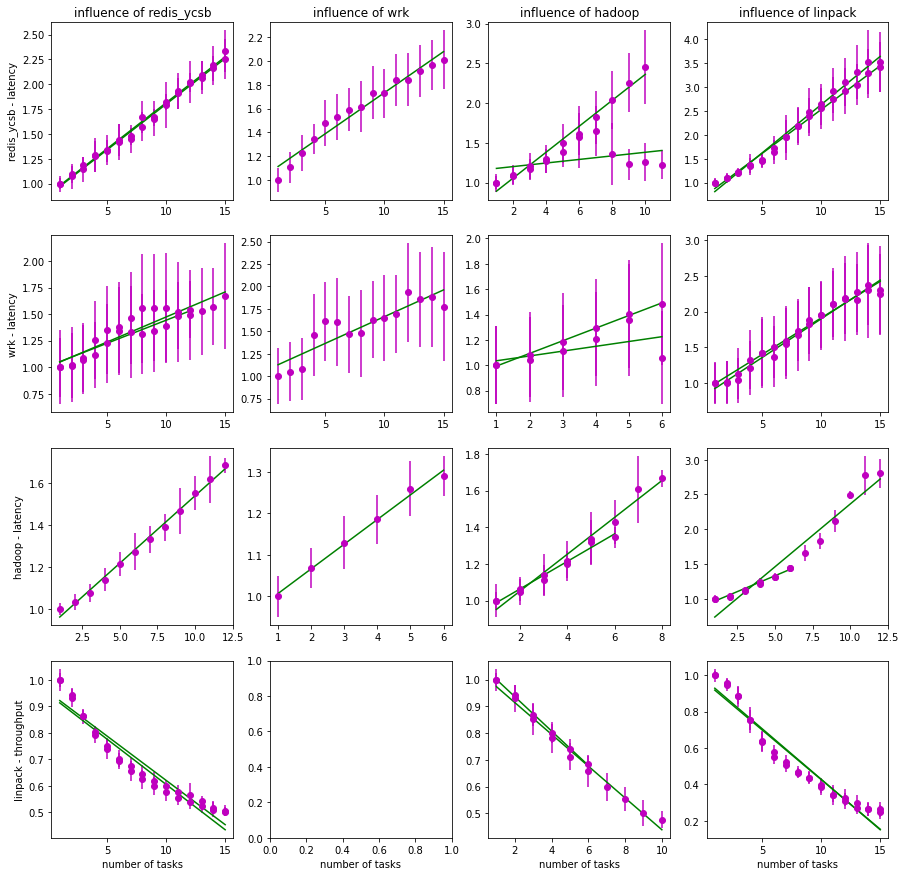

array([[[0.09251838, 0.06896643, 0.02253664, 0.18303585],
        [0.04346423, 0.05950165, 0.0996998 , 0.10239049],
        [0.06407131, 0.05943509, 0.07495003, 0.0910561 ],
        [0.03340253, 0.        , 0.06426189, 0.05550344]],

       [[0.09202281, 0.        , 0.16339007, 0.20164456],
        [0.04721765, 0.        , 0.03799307, 0.10846218],
        [0.        , 0.        , 0.10029655, 0.18047888],
        [0.03414553, 0.        , 0.05947115, 0.05454094]]])

In [53]:
analyzeInterferenceGrid([s2, s3], [res_s2["perf_vs_cpu"], res_s3["perf_vs_cpu"]])

In [95]:
result = {}
for t in s2.tasks:
    expid = s2.getExperiment(t, t)
    print(expid.expid)
    result[expid.expid] = readExp(expid)
print(result.keys())

completion_time = []
for expid, df in result.items():
    print(expid)
    c = df.loc[df["ai_name"] == "ai_1" , "app_completion_time"].mean()
    completion_time.append(c)
print(completion_time)
    

101redis_ycsb
106wrk
116hadoop
111linpack
dict_keys(['101redis_ycsb', '106wrk', '116hadoop', '111linpack'])
101redis_ycsb
106wrk
116hadoop
111linpack
[1.8918032786885246, 1.4427906976744187, 44.79381443298969, 17.24773413897281]


In [ ]:
s7 = ExperimentSeries("data/7cpu_diff_dosa", ["redis_ycsb", "wrk", "hadoop", "linpack"], {"hadoopslave" : 2}, {})
readPerfVsCpu(s7)
printPerfVsCpu(s7)